# W266 Final Project: Nautral Language Processing on Wine Reviews 
Maria Corina Cabezas, Austin Doolitle

## Background

In [1]:
#add introduction

## Prerequisite Libraries

In [75]:
import random
import math
import collections
import os
import string

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from yellowbrick.regressor import PredictionError
from xgboost.sklearn import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import keras
import keras_bert

seed = 42
random.seed(seed)
np.random.seed(42)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.keras.backend.set_session(tf.Session(config=config));

[nltk_data] Downloading package punkt to /home/austin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/austin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration and Analysis

### Data Cleaning

In [3]:
# Read the data
df = pd.read_csv('./data/winemag-data-130k-v2.csv', index_col=0)
print(f'N Rows: {len(df.index)}')
df.head()

N Rows: 129971


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


The dataset contains a lot of duplicates. I noticed that simply running data.drop_duplicates() did not remove all of them, because some column values were slightly different. Nevertheless, the fact that the "Description" columns were identical was sufficient to determine these were not different reviews. I decided to drop all duplicates based on the description column alone.

In [4]:
df = df.drop_duplicates('description')
print(f'N Rows: {len(df.index)}')

N Rows: 119955


Let's look at the number of missing values on each column

In [5]:
df.isnull().sum(axis = 0)

country                     59
description                  0
designation              34532
points                       0
price                     8388
province                    59
region_1                 19558
region_2                 73195
taster_name              24912
taster_twitter_handle    29441
title                        0
variety                      1
winery                       0
dtype: int64

It makes sense to delete the columns that have a very large number of missing values like designation, region_2 and taster_twitter_handle

In [6]:
columns = ['designation','region_2','taster_twitter_handle']
df = df.drop(columns, axis=1)

We also noticed that price has 8388 missing values, so we will replace these with the average price of wine

In [7]:
# TODO Imputing is mostly meant for features, not for the target values.
# we should probably just drop missing values

imp=Imputer(missing_values="NaN", strategy="mean" )
df["price"]=imp.fit_transform(df[["price"]]).ravel()

/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Train/Test/Dev Split

 First we split our dataset into 3 sets, namely training set, dev set, and test set. This is so that we can be more confident at our models and to better compare the model options we come up with. Specifically, training set is used to train our models, dev set is used to optimize each model, and test set is used to evaluate performance of the model. We have assigned 20% of the total dataset to be the test set, 20% to be the dev set, and the rest being training set. We made the split here because it will be used in the Data Exploration.

In [8]:
# split it into train, dev, and test
# courtesy of https://stackoverflow.com/a/38251063
perm = np.random.permutation(df.index)
m = len(df.index)

train_percent = .6
dev_percent = .2

train_end = int(m * train_percent)
dev_end = int(m * dev_percent) + train_end

train_df = df.loc[perm[:train_end]]
dev_df = df.loc[perm[train_end:dev_end]]
test_df = df.loc[perm[dev_end:]]

print(f'Train shape: {train_df.shape}')
print(f'Dev shape: {dev_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (71973, 10)
Dev shape: (23991, 10)
Test shape: (23991, 10)


## Initial Investigation
Let's start by just looking at the data and seeing what pops out to us. We'll spend a little time looking at the continuous values points and price, and then spend more time looking at the words

In [9]:
train_df.describe(include='all')

,country,description,points,price,province,region_1,taster_name,title,variety,winery
count,71934,71973,71973.000000,71973.000000,71934,60248,56995,71973,71972,71973
unique,41,71973,NaN,NaN,387,1135,19,71515,627,14262
top,US,Violet and lavender lend a floral tone to this...,NaN,NaN,California,Napa Valley,Roger Voss,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,30183,1,NaN,NaN,20167,2536,14186,8,7319,122
mean,NaN,NaN,88.444625,35.712472,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,3.094782,40.882064,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,86.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,88.000000,28.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,91.000000,40.000000,NaN,NaN,NaN,NaN,NaN,NaN


### Points

It appears that the points are located between 80-100. This matches up with the source of the data that claims they do not publish reviews for any wine scored less than 80. More information on wine scoring can be viewed [here](https://www.winespectator.com/articles/scoring-scale)

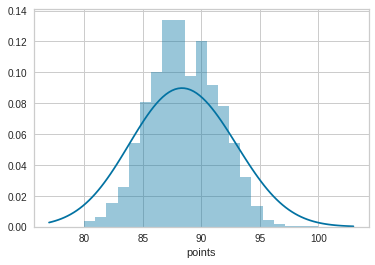

In [10]:
_ = sns.distplot(train_df.points, bins=21, kde_kws={'bw':1})

So it looks like this is a textbook normal distribution with an incredibly slight left skew. Let's just make sure that every value is represented.

In [11]:
print(np.sort(train_df.points.unique()))

[ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100]


### Price

Since this is related to currency, I bet my lunch this is a heavy tailed distribution. Let's see.

Missing values: 0


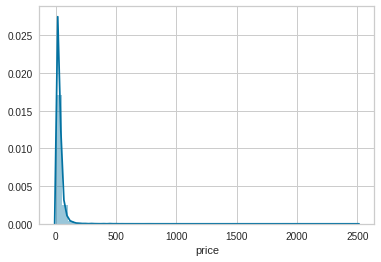

In [12]:
print(f'Missing values: {train_df.price.isna().sum()}')

# let's remove the missing prices for now
sns.distplot(train_df[~train_df.price.isna()].price)

Nice... lets log scale this.

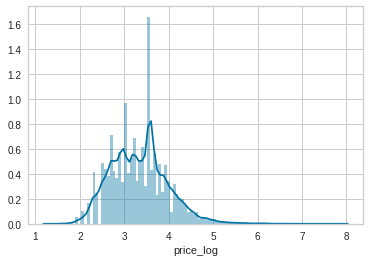

In [13]:
train_df['price_log'] = np.log(train_df.price)
ax = sns.distplot(train_df[~train_df.price_log.isna()].price_log, bins=100)

Just out of curiosity, I see that the lowest price is 4 dollars... what's the score on those?

In [14]:
train_df[train_df.price == 4].points.mean()

84.0

### String Columns

In [15]:
non_cont_columns = train_df.columns[train_df.dtypes == np.object]
print(f'Non-Continuous columns: {list(non_cont_columns)}')

Non-Continuous columns: ['country', 'description', 'province', 'region_1', 'taster_name', 'title', 'variety', 'winery']


Let's start by focusing on the descriptions. We'll tokenize, canonize, construct a vocabulary, and finally get counts for each of the items.

In [16]:
counter = collections.Counter()

for s in train_df.description:
    s = s.lower()
    tokenized = nltk.tokenize.word_tokenize(s)
    counter.update(tokenized)

vocab = counter.items()
print(len(vocab))

36322


In [17]:
# view most common words 
most_common = counter.most_common(50)
print(most_common)

[(',', 244550), ('.', 195930), ('and', 192668), ('the', 122715), ('a', 99833), ('of', 95882), ('with', 66938), ('this', 62921), ('is', 53915), ('it', 47719), ('wine', 44307), ('flavors', 34799), ('in', 34600), ('to', 30886), ("'s", 28777), ('fruit', 24959), ('on', 24838), ('that', 22421), ('aromas', 21744), ('palate', 20796), ('acidity', 19211), ('finish', 19166), ('from', 18095), ('but', 17424), ('tannins', 17170), ('drink', 16626), ('cherry', 15161), ('ripe', 14758), ('are', 14416), ('black', 13979), ('has', 13629), ('for', 12168), ('by', 11310), ('%', 10453), ('notes', 10424), ('spice', 10393), ('red', 10345), ('as', 10136), ('an', 10061), ('its', 10050), ('rich', 9685), ('nose', 9287), ('oak', 9247), ('fresh', 9241), ('berry', 8645), ('dry', 8608), ('now', 8421), ('plum', 7815), ('soft', 7524), ('fruits', 7448)]


One very interesting thing viewed here is that in the most common words are very wine specific words. This is pretty obvious in hindsight, but it made me laugh to see wine just outside of the top 10.

Now we would like to see a wordcloud view of the most common words excluding punctuations and stopwords. We also excluded other common words like drink, wine, flavors etc.

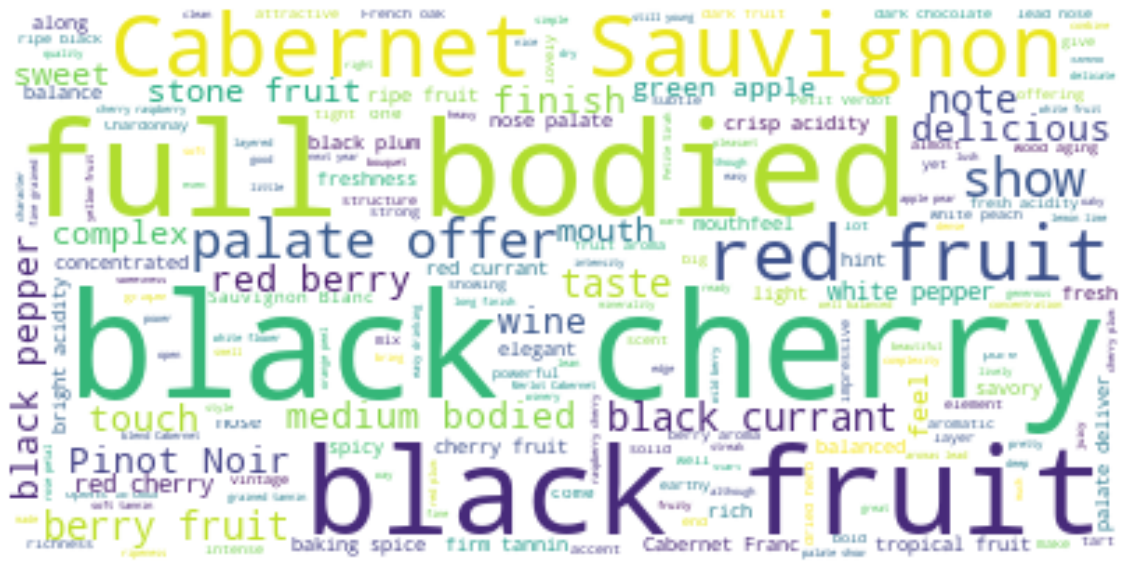

In [18]:
text = " ".join(review for review in df.description)
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

It seems black cherry and full bodied are the most common characteristics and Carbernet Sauvignon is the most discussed type of wine. Let's see if this is due to it being more common in the dataset

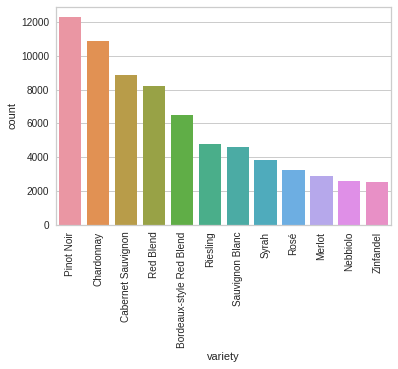

In [19]:
variety_df = df.groupby('variety').filter(lambda x: len(x) > 2500)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (6, 4))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()


Surprisingly, Cabernet Sauvignon was the third most reviewed wine variety after Pinot Noir and Chardonnay.

### Tasters
Now let's look at the tasters. We'll see how many there are, and the distribution of the number of reviews each has given

19 Tasters: ['Michael Schachner', 'Joe Czerwinski', 'Roger Voss', 'Anne Krebiehl\xa0MW', 'Sean P. Sullivan', 'Paul Gregutt', 'Virginie Boone', 'Carrie Dykes', 'Kerin O’Keefe', 'Anna Lee C. Iijima', 'Matt Kettmann', 'Jim Gordon', 'Lauren Buzzeo', 'Mike DeSimone', 'Susan Kostrzewa', 'Jeff Jenssen', 'Alexander Peartree', 'Fiona Adams', 'Christina Pickard']


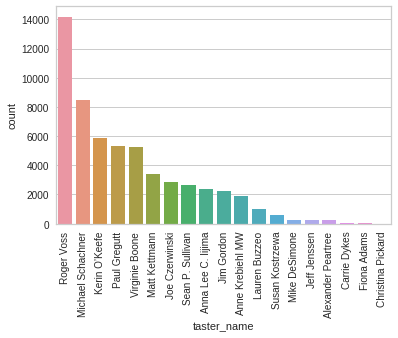

In [20]:
tasters = train_df.taster_name.dropna().unique()
print(f'{len(tasters)} Tasters: {list(tasters)}')
train_df.taster_name = train_df.taster_name.astype('category')

taster_counts  = train_df.taster_name.value_counts()
ax = sns.countplot(train_df.taster_name, order=taster_counts.index)
_ = ax.set_xticklabels(taster_counts.index, rotation=90)

As expected, there appears to be a Zeta distribution in the contributions of each taster. Let's what the numbers are on the 3 least active contributors: Carrie Dykes, Fiona Adams, and Christina Pickard.

In [21]:
print(taster_counts[['Carrie Dykes', 'Fiona Adams', 'Christina Pickard']])

Carrie Dykes         69
Fiona Adams          16
Christina Pickard     3
Name: taster_name, dtype: int64


We'll need to keep this in mind for subsequent analysis since the data related to their contributions will likely not be as representative as someone on the center or left of the distribution

#### Taster Vocabulary
Just for funsies, let's look at the vocabulary of each individual taster

In [22]:
taster_vocabs = {n: collections.Counter() for n in tasters}

for _, row in train_df[~train_df.taster_name.isna()].iterrows():
    taster = row.taster_name
    s = row.description
    s = s.lower()
    tokenized = nltk.tokenize.word_tokenize(s)
    taster_vocabs[taster].update(tokenized)

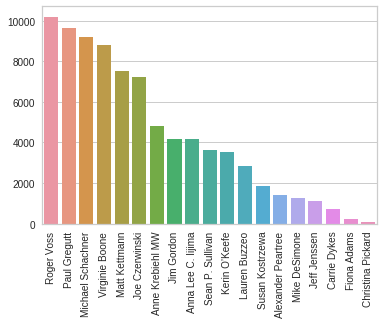

In [23]:
taster_vocab_lens = {k: len(v.items()) for k, v in taster_vocabs.items()}
taster_vocab_lens = pd.Series(taster_vocab_lens).sort_values().iloc[::-1]

ax = sns.barplot(x=taster_vocab_lens.index, y=taster_vocab_lens)
_ = ax.set_xticklabels(taster_vocab_lens.index, rotation=90)

As expected, Roger Voss is up top since he has had the most opportunity to use unique words. Let's compare the two lists.

In [24]:
compare_list = []

contribution_count_list = list(taster_counts.index)

print('Vocab Size compared to Contribution:')
for vocab_idx, taster in enumerate(taster_vocab_lens.index):
    count_idx = contribution_count_list.index(taster)
    diff = count_idx - vocab_idx
    print(f'\t{vocab_idx + 1}: {taster} ({diff:+d})')

Vocab Size compared to Contribution:
	1: Roger Voss (+0)
	2: Paul Gregutt (+2)
	3: Michael Schachner (-1)
	4: Virginie Boone (+1)
	5: Matt Kettmann (+1)
	6: Joe Czerwinski (+1)
	7: Anne Krebiehl MW (+4)
	8: Jim Gordon (+2)
	9: Anna Lee C. Iijima (+0)
	10: Sean P. Sullivan (-2)
	11: Kerin O’Keefe (-8)
	12: Lauren Buzzeo (+0)
	13: Susan Kostrzewa (+0)
	14: Alexander Peartree (+2)
	15: Mike DeSimone (-1)
	16: Jeff Jenssen (-1)
	17: Carrie Dykes (+0)
	18: Fiona Adams (+0)
	19: Christina Pickard (+0)


Kerin O'Keefe appears to be relatively bland in her word usage. 

#### Taster Score Distribution
Let's look at each reviewer's score distribution to make sure we don't have any biased reviewers

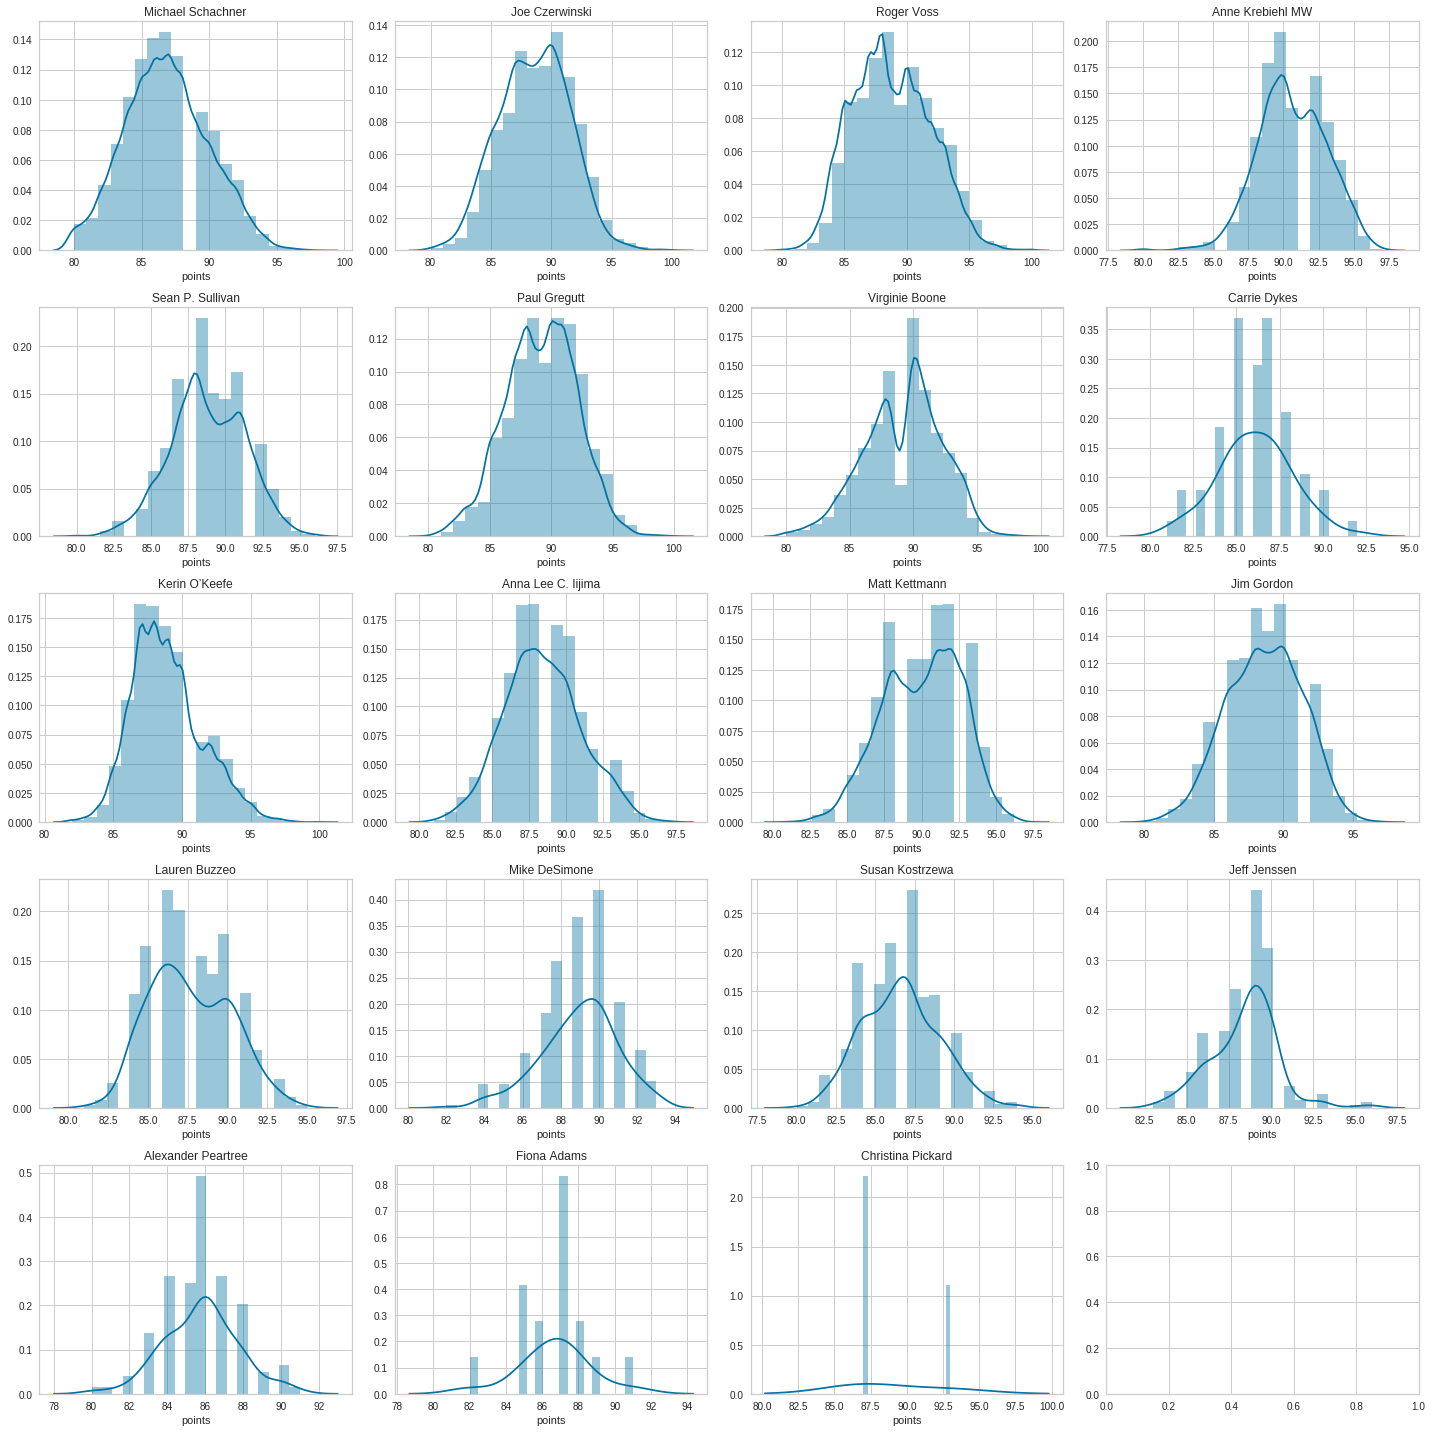

In [25]:
cols = 4
rows = math.ceil(len(tasters) / float(cols))
figs, axes = plt.subplots(rows, cols, figsize=(20,20))
axes = axes.flatten()
for taster, ax in zip(tasters, axes):
    taster_reviews = train_df[train_df.taster_name == taster]
    ax = sns.distplot(taster_reviews.points, ax=ax, bins=20)
    ax.set_title(taster)

plt.tight_layout()

There isn't any bias immediately apparent for any of the reviewers, although this is difficult to ascertain due to the large range in the number of reviews per taster.

#### Taster Price Distribution

And now let's look at the distribution of the log price for each reviewer

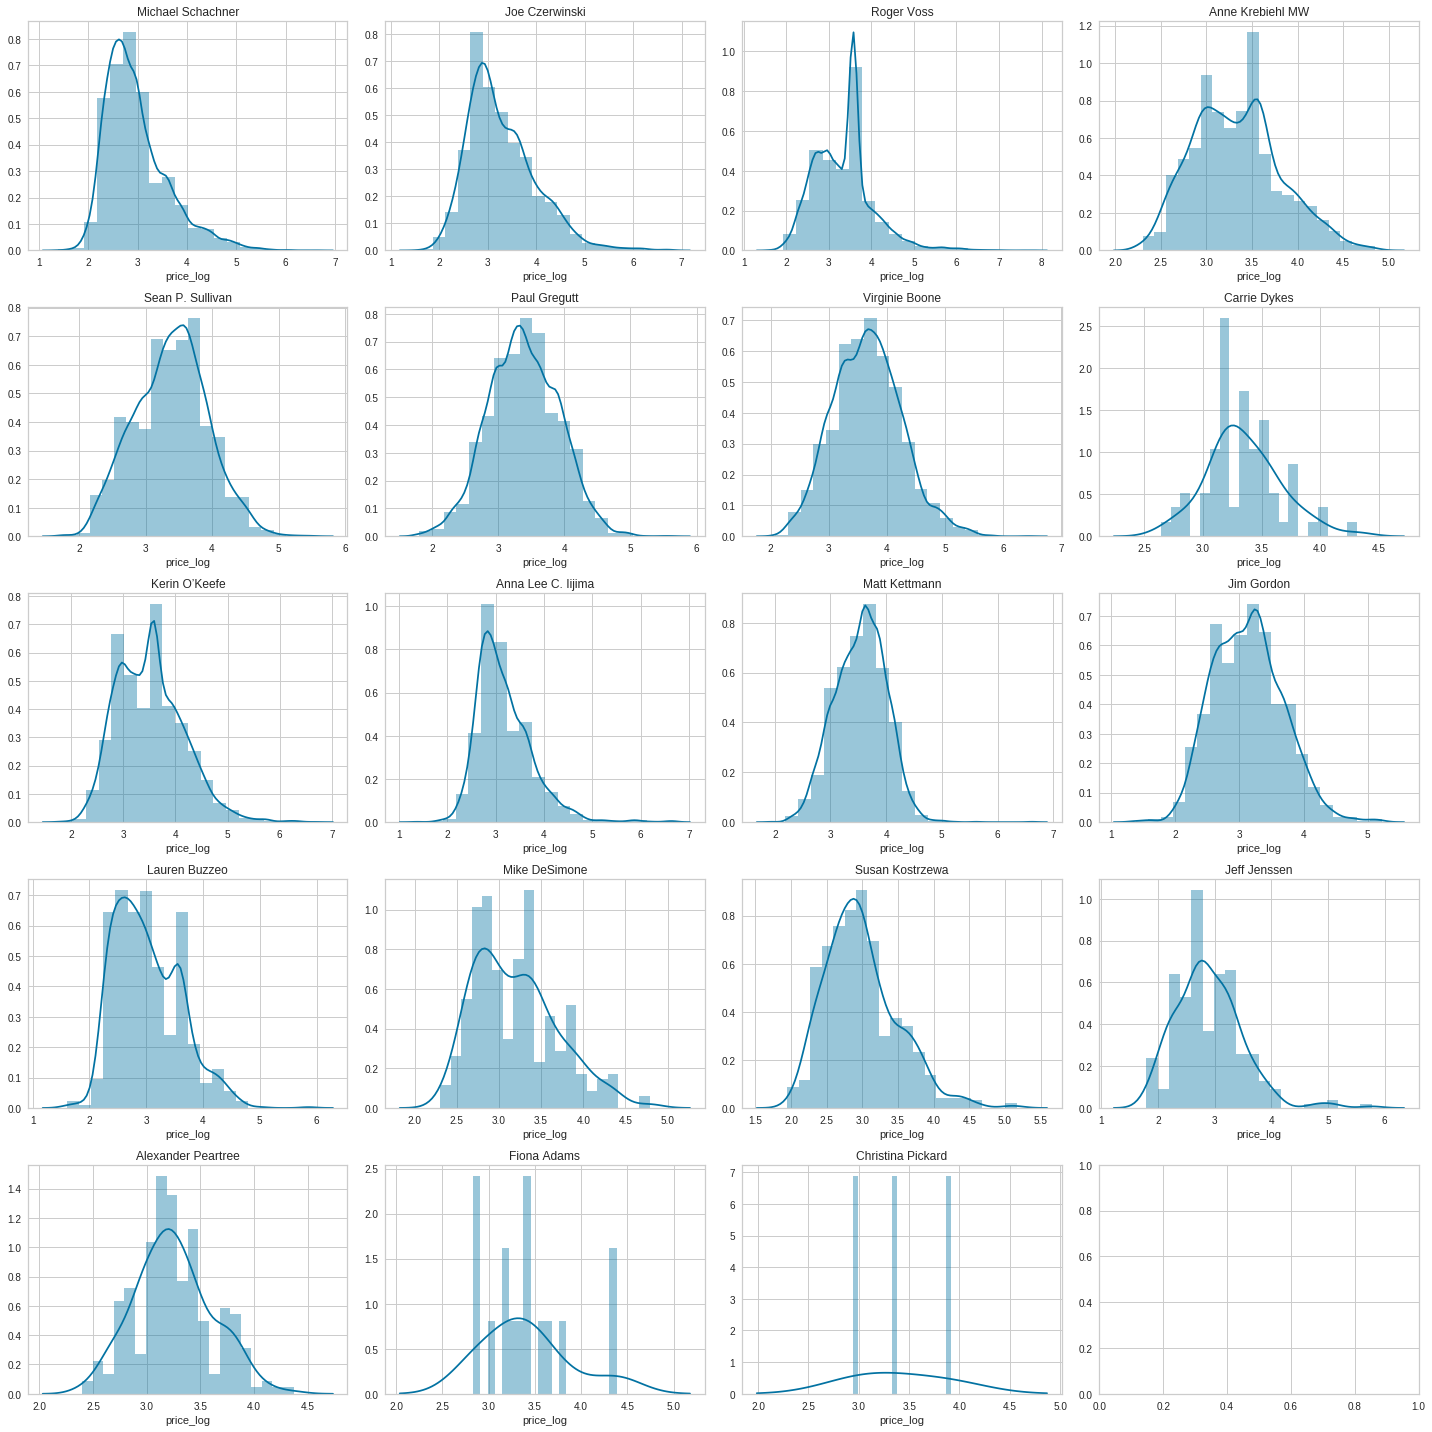

In [26]:
cols = 4
rows = math.ceil(len(tasters) / float(cols))
figs, axes = plt.subplots(rows, cols, figsize=(20,20))
axes = axes.flatten()
for taster, ax in zip(tasters, axes):
    taster_reviews = train_df[(train_df.taster_name == taster) & ~train_df.price_log.isna()]
    ax = sns.distplot(taster_reviews.price_log, ax=ax, bins=20)
    ax.set_title(taster)

plt.tight_layout()

### Unique Words
Let's look at the top 3 unique words used by the tasters. We'll do this by iteratively constructing of the top 3 words used by each taster and removing any duplicate words across top 3 lists.

In [27]:
stop_words = nltk.corpus.stopwords.words('english')

# collect the top 25 words from the corpus (not including nltk stop words)
top_domain_specific_words = []
n = 25
for word, count in counter.most_common():
    if word in stop_words:
        continue
    
    top_domain_specific_words.append(word)
    if len(top_domain_specific_words) == n:
        break
        
all_stop_words = list(string.punctuation) + top_domain_specific_words + stop_words

n = 3
top_vocab = {}
for taster_name in taster_vocabs:
    taster_vocab = taster_vocabs[taster_name]
    
    unique_words = []
    for word, count in taster_vocab.most_common():
        if word in all_stop_words:
            continue
        
        unique_words.append(word)
        if len(unique_words) == n:
            break
        
    top_vocab[taster_name] = unique_words
        
for taster_name, words in top_vocab.items():
    print(f'{taster_name}: ')
    for i, w in enumerate(words):
        print(f'\t{i+1}: {w}')

Michael Schachner: 
	1: plum
	2: herbal
	3: blackberry
Joe Czerwinski: 
	1: hints
	2: long
	3: slightly
Roger Voss: 
	1: fruits
	2: character
	3: fruity
Anne Krebiehl MW: 
	1: freshness
	2: lemon
	3: pear
Sean P. Sullivan: 
	1: cabernet
	2: herb
	3: herbs
Paul Gregutt: 
	1: light
	2: blend
	3: tart
Virginie Boone: 
	1: cabernet
	2: soft
	3: texture
Carrie Dykes: 
	1: long
	2: peach
	3: lemon
Kerin O’Keefe: 
	1: offers
	2: alongside
	3: white
Anna Lee C. Iijima: 
	1: riesling
	2: peach
	3: apple
Matt Kettmann: 
	1: bottling
	2: shows
	3: dried
Jim Gordon: 
	1: texture
	2: like
	3: full-bodied
Lauren Buzzeo: 
	1: plum
	2: mouth
	3: sweet
Mike DeSimone: 
	1: bright
	2: offers
	3: soft
Susan Kostrzewa: 
	1: pair
	2: white
	3: elegant
Jeff Jenssen: 
	1: lemon
	2: apple
	3: mouth
Alexander Peartree: 
	1: lemon
	2: peach
	3: shows
Fiona Adams: 
	1: blackberry
	2: pepper
	3: cedar
Christina Pickard: 
	1: blend
	2: valley
	3: creamy


Let's see what words are most strongly correlated with price

In [28]:
score_vec = CountVectorizer(
    lowercase=True,
    stop_words=stop_words,
    ngram_range=(1,1),
    min_df=10
)
X_score = score_vec.fit_transform(train_df.description)

In [29]:
def get_corr(x, y):
    y = np.expand_dims(y, axis=0)
    x = x.toarray().T
    points_np = np.concatenate([x, y], axis=0)
    return np.corrcoef(points_np)[-1][:-1]

In [30]:
score_corr = get_corr(X_score, train_df.points)

Highest correlations:
	1. condrieu: 0.18846072194802047
	2. briar: 0.17786407431566117
	3. distracts: 0.1715503872395598
	4. may: 0.15604950917588478
	5. longtime: 0.15404710181139092
	6. distinguish: 0.1535664950624644
	7. harshness: 0.15227968582634066
	8. fresh: 0.14341749705373438
	9. salty: 0.14043074197622787
Lowest correlations:
	1. durell: -0.1848828857197363
	2. telltale: -0.10513829973226244
	3. ownership: -0.1000436767460718
	4. gewürz: -0.09407216068201749
	5. graham: -0.09251231141124912
	6. puckery: -0.09189595037814836
	7. minty: -0.09034248140546888
	8. subside: -0.08941012830247891
	9. unripeness: -0.08845764387054166
	10. tamari: -0.08588397244298394


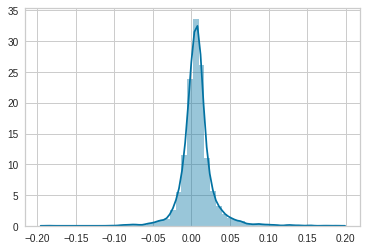

In [31]:
def display_corr(corr, vec):
    n = 10
    corr_sorted_idx = np.argsort(corr)
    vocab_words = list(vec.vocabulary_.keys())
    
    print('Highest correlations:')
    for i, idx in enumerate(corr_sorted_idx[-1:-n:-1]):
        corr_val = corr[idx]
        word = vocab_words[idx]
        print(f'\t{i+1}. {word}: {corr_val}')

    print('Lowest correlations:')
    for i, idx in enumerate(corr_sorted_idx[:n]):
        corr_val = corr[idx]
        word = vocab_words[idx]
        print(f'\t{i+1}. {word}: {corr_val}')
    
    # plot the correlations
    sorted_score_corr = score_corr[corr_sorted_idx]
    _ = sns.distplot(sorted_score_corr)
    
display_corr(score_corr, score_vec)

Let's do the same thing but for price

In [32]:
train_price_df = train_df.dropna(subset=['price'], axis=0, inplace=False)

price_vec = CountVectorizer(
    lowercase=True,
    stop_words=stop_words,
    ngram_range=(1,1),
    min_df=10
)
X_price = price_vec.fit_transform(train_price_df.description)
price_corr = get_corr(X_price, train_price_df.price)

Highest correlations:
	1. condrieu: 0.1393196199325553
	2. ink: 0.12171367082658564
	3. morning: 0.11708976142241267
	4. yet: 0.10121546182704148
	5. distracts: 0.09948626789820411
	6. join: 0.0980341223754984
	7. increasing: 0.09214415030004221
	8. fresh: 0.08857822997447523
	9. dishes: 0.08614535815007879
Lowest correlations:
	1. previous: -0.0661173077321595
	2. ownership: -0.06437825430622383
	3. durell: -0.06228660151331065
	4. associated: -0.06217504461283863
	5. throughout: -0.061967349202132455
	6. unripeness: -0.060688114596728474
	7. spot: -0.05930385375016646
	8. meatiness: -0.05788073495557484
	9. mendocino: -0.05742130917161391
	10. promise: -0.05529552853239445


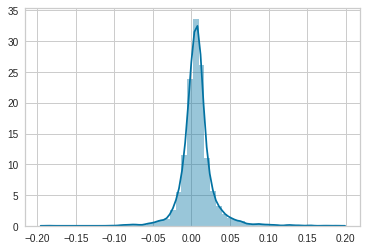

In [33]:
display_corr(price_corr, price_vec)

# NLP Models

## Regression Models

MSE: 0.00768


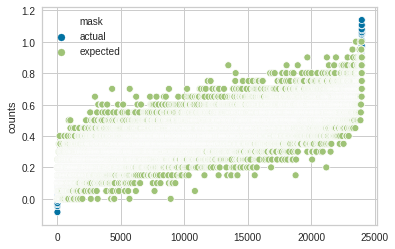

In [52]:
def signorm(d):
    d = np.array(d, dtype=np.float32)
    d_min = d.min()
    return (d - d_min) / (d.max() - d.min())

def zero_mean_norm(d):
    d = np.array(d)
    return (d - d.mean()) / d.std()

# idk how else to do this, I'm so sorry
def plot_predicted_vs_actual(actual_labels, expected_labels):
    sorted_y = np.argsort(actual_labels, axis=0)

    actual_sorted = np.squeeze(actual_labels[sorted_y])
    expected_sorted = np.squeeze(expected_labels[sorted_y])
    temp_df = pd.DataFrame()
    temp_df['counts'] = np.concatenate([actual_sorted, expected_sorted])

    mask = np.concatenate([np.ones_like(actual_sorted), np.zeros_like(expected_sorted)])
    lut = {
        1: 'actual',
        0: 'expected'
    }
    temp_df['mask'] = mask
    temp_df['mask'] = temp_df['mask'].map(lut)

    index = np.tile(np.arange(actual_sorted.shape[0]), 2)
    ax = sns.scatterplot(index, 'counts', hue='mask', data=temp_df)

def train_and_show(model, x, y, x_dev, y_dev):
    visualizer = PredictionError(model)

    model.fit(x, y)  # Fit the training data to the visualizer
    y_dev_predict = model.predict(x_dev)  # Evaluate the model on the test data
    plot_predicted_vs_actual(y_dev_predict, y_dev)
    
    mse_val = metrics.mean_squared_error(y_dev, y_dev_predict)
    print(f'MSE: {mse_val:.5f}')
    
X_score_dev = score_vec.transform(dev_df.description)

y_score_train = signorm(train_df.points).reshape(-1,1)
y_score_dev = signorm(dev_df.points).reshape(-1,1)
train_and_show(LinearRegression(), X_score, y_score_train, X_score_dev, y_score_dev)

## Classification Models

### By Variety

#### K-Nearest Neighbors 

In [35]:
# X_train = list(train_df['description'].astype(str))
# y_train = train_df['variety'].astype(str)
# X_dev = list(dev_df['description'].astype(str))
# y_dev = dev_df['variety'].astype(str)
# print(len(X_train), y_train.shape, len(X_dev), y_dev.shape)

In [36]:
# vectorizer = CountVectorizer()
# train_featurevectors = vectorizer.fit_transform(X_train)
# dev_featurevectors = vectorizer.transform(X_dev)

# #hyperparameter tuning
# param = {'n_neighbors': np.concatenate([np.arange(1,50,1),np.arange(50,100,2),np.arange(100,201,5)]).tolist()}
# knn_bestparam = GridSearchCV(KNeighborsClassifier(), param, scoring='f1_macro')
# knn_bestparam.fit(train_featurevectors, y_train)
# optimal_k = knn_bestparam.best_params_['n_neighbors']

# #model 
# knn = KNeighborsClassifier(n_neighbors=optimal_k)
# knn.fit(train_featurevectors, y_train)
# predictions = knn.predict(dev_featurevectors)
# print('F1 score for a kNN classifier using k=90:', '{0:.4f}'.format(metrics.f1_score(y_dev,predictions, average='macro')))

### By Region

#### K-Nearest Neighbors 

In [37]:
# y_train = train_df['region'].astype(str)
# y_dev = dev_df['region'].astype(str)
# print(len(X_train), y_train.shape, len(X_dev), y_dev.shape)

In [38]:
# vectorizer = CountVectorizer()
# train_featurevectors = vectorizer.fit_transform(X_train)
# dev_featurevectors = vectorizer.transform(X_dev)

# #hyperparameter tuning
# param = {'n_neighbors': np.concatenate([np.arange(1,50,1),np.arange(50,100,2),np.arange(100,201,5)]).tolist()}
# knn_bestparam = GridSearchCV(KNeighborsClassifier(), param, scoring='f1_macro')
# knn_bestparam.fit(train_featurevectors, y_train)
# optimal_k = knn_bestparam.best_params_['n_neighbors']

# #train the model with optimal hyperparameters
# knn = KNeighborsClassifier(n_neighbors=90)
# knn.fit(train_featurevectors, y_train)
# predictions = knn.predict(dev_featurevectors)
# print("Knn Classification report")
# print('F1 score for a kNN classifier using k=90:', '{0:.4f}'.format(metrics.f1_score(y_dev,predictions, average='macro')))

In [39]:
# The longest description, including start and end tokens
max_len = 130

def surround_texts(texts):
    return [f'SSS {t} EEE' for t in texts]

t = keras.preprocessing.text.Tokenizer()
surrounded_train = surround_texts(train_df.description)
t.fit_on_texts(surrounded_train)
vocab_size = len(t.word_counts) + 1

def get_dataset(data, label, sigmoid_norm=False):
    """
    FYI setting sigmoid_norm to False normalizes mean to 0 and variance to 1
    Setting to True scales linearly to range [0-1]
    """
    surrounded_series = surround_texts(data)
    seq = t.texts_to_sequences(surrounded_series)
    pad =  keras.preprocessing.sequence.pad_sequences(
        seq, 
        maxlen=max_len,
        padding='post',
        truncating='post',
    )
    
    label = np.array(label, dtype=np.float32)
    if sigmoid_norm:
        label_norm = signorm(label)
    else:
        label_norm = (label - label.mean()) / label.std()
    
    return pad, label_norm

train_X, train_y = get_dataset(train_df.description, train_df.points, sigmoid_norm=True)
dev_X, dev_y = get_dataset(dev_df.description, dev_df.points, sigmoid_norm=True)
test_X, test_y = get_dataset(test_df.description, test_df.points, sigmoid_norm=True)

In [67]:
# create our CNN model
def train_cnn(train_X, train_y, dev_X, dev_y, batch_size=256, embedding_dim=256, lr=1e-4, output_dir='./out/cnn', epochs=15, loss='mean_absolute_error', metrics=['mae']):
    os.makedirs(output_dir, exist_ok=True)

    inputs = keras.layers.Input((max_len,))
    embedding = keras.layers.Embedding(input_dim=vocab_size + 2, output_dim=embedding_dim, input_length=max_len)(inputs)
    reshape = keras.layers.Reshape((max_len,embedding_dim,1))(embedding)

    conv0_0 = keras.layers.Conv2D(256, kernel_size=(3, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv0_1 = keras.layers.Conv2D(256, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv0_2 = keras.layers.Conv2D(256, kernel_size=(5, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool0_0 = keras.layers.MaxPool2D(pool_size=(max_len - 3 + 1, 1), strides=(1,1), padding='valid')(conv0_0)
    maxpool0_1 = keras.layers.MaxPool2D(pool_size=(max_len - 4 + 1, 1), strides=(1,1), padding='valid')(conv0_1)
    maxpool0_2 = keras.layers.MaxPool2D(pool_size=(max_len - 5 + 1, 1), strides=(1,1), padding='valid')(conv0_2)

    concat = keras.layers.Concatenate(axis=1)([maxpool0_0, maxpool0_1, maxpool0_2])
    flatten = keras.layers.Flatten()(concat)
    dropout = keras.layers.Dropout(0.1)(flatten)
    output = keras.layers.Dense(units=1, activation='sigmoid')(dropout)

    model = keras.models.Model(inputs, output)

    chkpt = keras.callbacks.ModelCheckpoint('./out/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_mse', verbose=1, save_best_only=True, mode='auto')
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # TODO try different loss functions
    model.compile(optimizer=adam, loss=loss, metrics=metrics)
    print("Training Model...")
    model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[chkpt], validation_data=(dev_X, dev_y))  # starts training
    return model

model = train_cnn(train_X, train_y, dev_X, dev_y, loss='binary_crossentropy', metrics=['mse'], epochs=7)



Training Model...
Train on 71973 samples, validate on 23991 samples
Epoch 1/7
71973/71973 [==============================] - 15s 209us/step - loss: 0.6687 - mse: 0.0180 - val_loss: 0.6556 - val_mse: 0.0117

Epoch 00001: val_mse improved from inf to 0.01166, saving model to ./out/weights.001-0.6556.hdf5
Epoch 2/7
71973/71973 [==============================] - 15s 202us/step - loss: 0.6499 - mse: 0.0092 - val_loss: 0.6480 - val_mse: 0.0082

Epoch 00002: val_mse improved from 0.01166 to 0.00821, saving model to ./out/weights.002-0.6480.hdf5
Epoch 3/7
71973/71973 [==============================] - 14s 200us/step - loss: 0.6452 - mse: 0.0071 - val_loss: 0.6461 - val_mse: 0.0074

Epoch 00003: val_mse improved from 0.00821 to 0.00737, saving model to ./out/weights.003-0.6461.hdf5
Epoch 4/7
71973/71973 [==============================] - 14s 200us/step - loss: 0.6429 - mse: 0.0060 - val_loss: 0.6453 - val_mse: 0.0070

Epoch 00004: val_mse improved from 0.00737 to 0.00701, saving model to ./out/

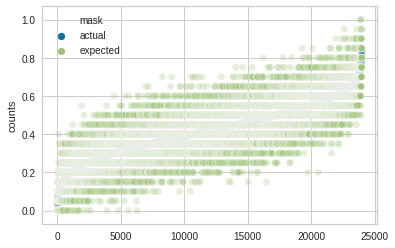

In [51]:
out = model.predict(dev_X)
plot_predicted_vs_actual(out, dev_y)

In [79]:
model = keras_bert.get_model(
    token_num=vocab_size,
    head_num=5,
    transformer_num=12,
    embed_dim=25,
    feed_forward_dim=100,
    seq_len=20,
    pos_num=20,
    dropout_rate=0.05,
)
keras_bert.compile_model(model)

In [83]:

chkpt = keras.callbacks.ModelCheckpoint('./out/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_mse', verbose=1, save_best_only=True, mode='auto')

model.fit(train_X, train_y, batch_size=100, epochs=100, verbose=1, callbacks=[chkpt], validation_data=(dev_X, dev_y))  # starts training

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 1 arrays: [array([[   5,  121,   17, ...,    0,    0,    0],
       [   5,  712,    1, ...,    0,    0,    0],
       [   5, 8368, 2095, ...,    0,    0,    0],
       ...,
       [   5,    3,  100, ...,    0, ...

Meeting Notes:
- Add Price correlation with each word in vocab
  - Make algo more memory efficient
- Establish a baseline
    - Binary Classifier
    - Linear Regression on Highest and Lowest correlation words
        - Price
        - Points
- Do same analysis on Bigrams/Trigrams/NGrams
- Train new models
    - CNN approach
    - LSTM
    - BERT
    - Tasks?
        - Price Regression
        - Score Regression
        - Region Classification
        - Variety Classification
        - Sentiment analysis by Winery
- Appendix
    - Country specific
    - Region specific
    - Taster specific